# Comparison of various Decision Tree Classification Algorithm

In [54]:
from IPython.display import display
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler, InstanceHardnessThreshold, NearMiss

The warning is thrown by xgboost. It has been fixed in the new stable version 1.6, which is not yet available for anaconda at this moment. The warning will come up several times, but does not interfere with the analysis.

## Load the Data
And Data inspection

In [29]:
data = pd.read_csv("data/heart_prep.csv", sep=",")
print("Number of valid entries:", len(data))
data.describe()

Number of valid entries: 319795


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
count,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.00000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000
mean,0.085595,28.325399,0.412477,0.068097,0.037740,3.37171,3.898366,0.138870,0.475273,6.514536,4.396742,0.419972,0.775362,2.595028,7.097075,0.134061,0.036833,0.093244
std,0.279766,6.356100,0.492281,0.251912,0.190567,7.95085,7.955235,0.345812,0.499389,3.564759,1.212208,1.012487,0.417344,1.042918,1.436007,0.340718,0.188352,0.290775
min,0.000000,12.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,24.030000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,5.000000,0.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000
50%,0.000000,27.340000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,7.000000,5.000000,0.000000,1.000000,3.000000,7.000000,0.000000,0.000000,0.000000
75%,0.000000,31.420000,1.000000,0.000000,0.000000,2.00000,3.000000,0.000000,1.000000,9.000000,5.000000,0.000000,1.000000,3.000000,8.000000,0.000000,0.000000,0.000000
max,1.000000,94.850000,1.000000,1.000000,1.000000,30.00000,30.000000,1.000000,1.000000,12.000000,5.000000,3.000000,1.000000,4.000000,24.000000,1.000000,1.000000,1.000000


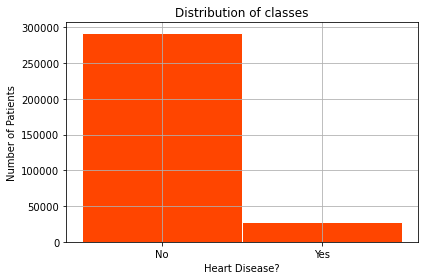

HeartDisease        27373
BMI                 27373
Smoking             27373
AlcoholDrinking     27373
Stroke              27373
PhysicalHealth      27373
MentalHealth        27373
DiffWalking         27373
Sex                 27373
AgeCategory         27373
Race                27373
Diabetic            27373
PhysicalActivity    27373
GenHealth           27373
SleepTime           27373
Asthma              27373
KidneyDisease       27373
SkinCancer          27373
dtype: int64

<Figure size 432x288 with 0 Axes>

In [30]:
#Plotting class distribution of HeartDisease to show off imbalance
data['HeartDisease'].hist(bins = 2, edgecolor='white', color='orangered')
plt.xticks(ticks=[0.25, 0.75], labels=['No', 'Yes'])
plt.title('Distribution of classes')
plt.xlabel('Heart Disease?')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.savefig('figures/distributions/distribution.png')
plt.show()
plt.clf()
data[data.HeartDisease == 1].count() 

In [31]:
#Preparation of target data Y, rest data X
data_target = data['HeartDisease']
data = data.drop(['HeartDisease'], axis=1)
#Generating Training and Test datasets in ratio 3:2
train, test, target_train, target_test = train_test_split(data, data_target, test_size=0.4, random_state=0)
print("Size Training dataset: ", len(train), "\nSize Test dataset: ", len(test)) #"\nSize Validation dataset", len(val))


Size Training dataset:  191877 
Size Test dataset:  127918


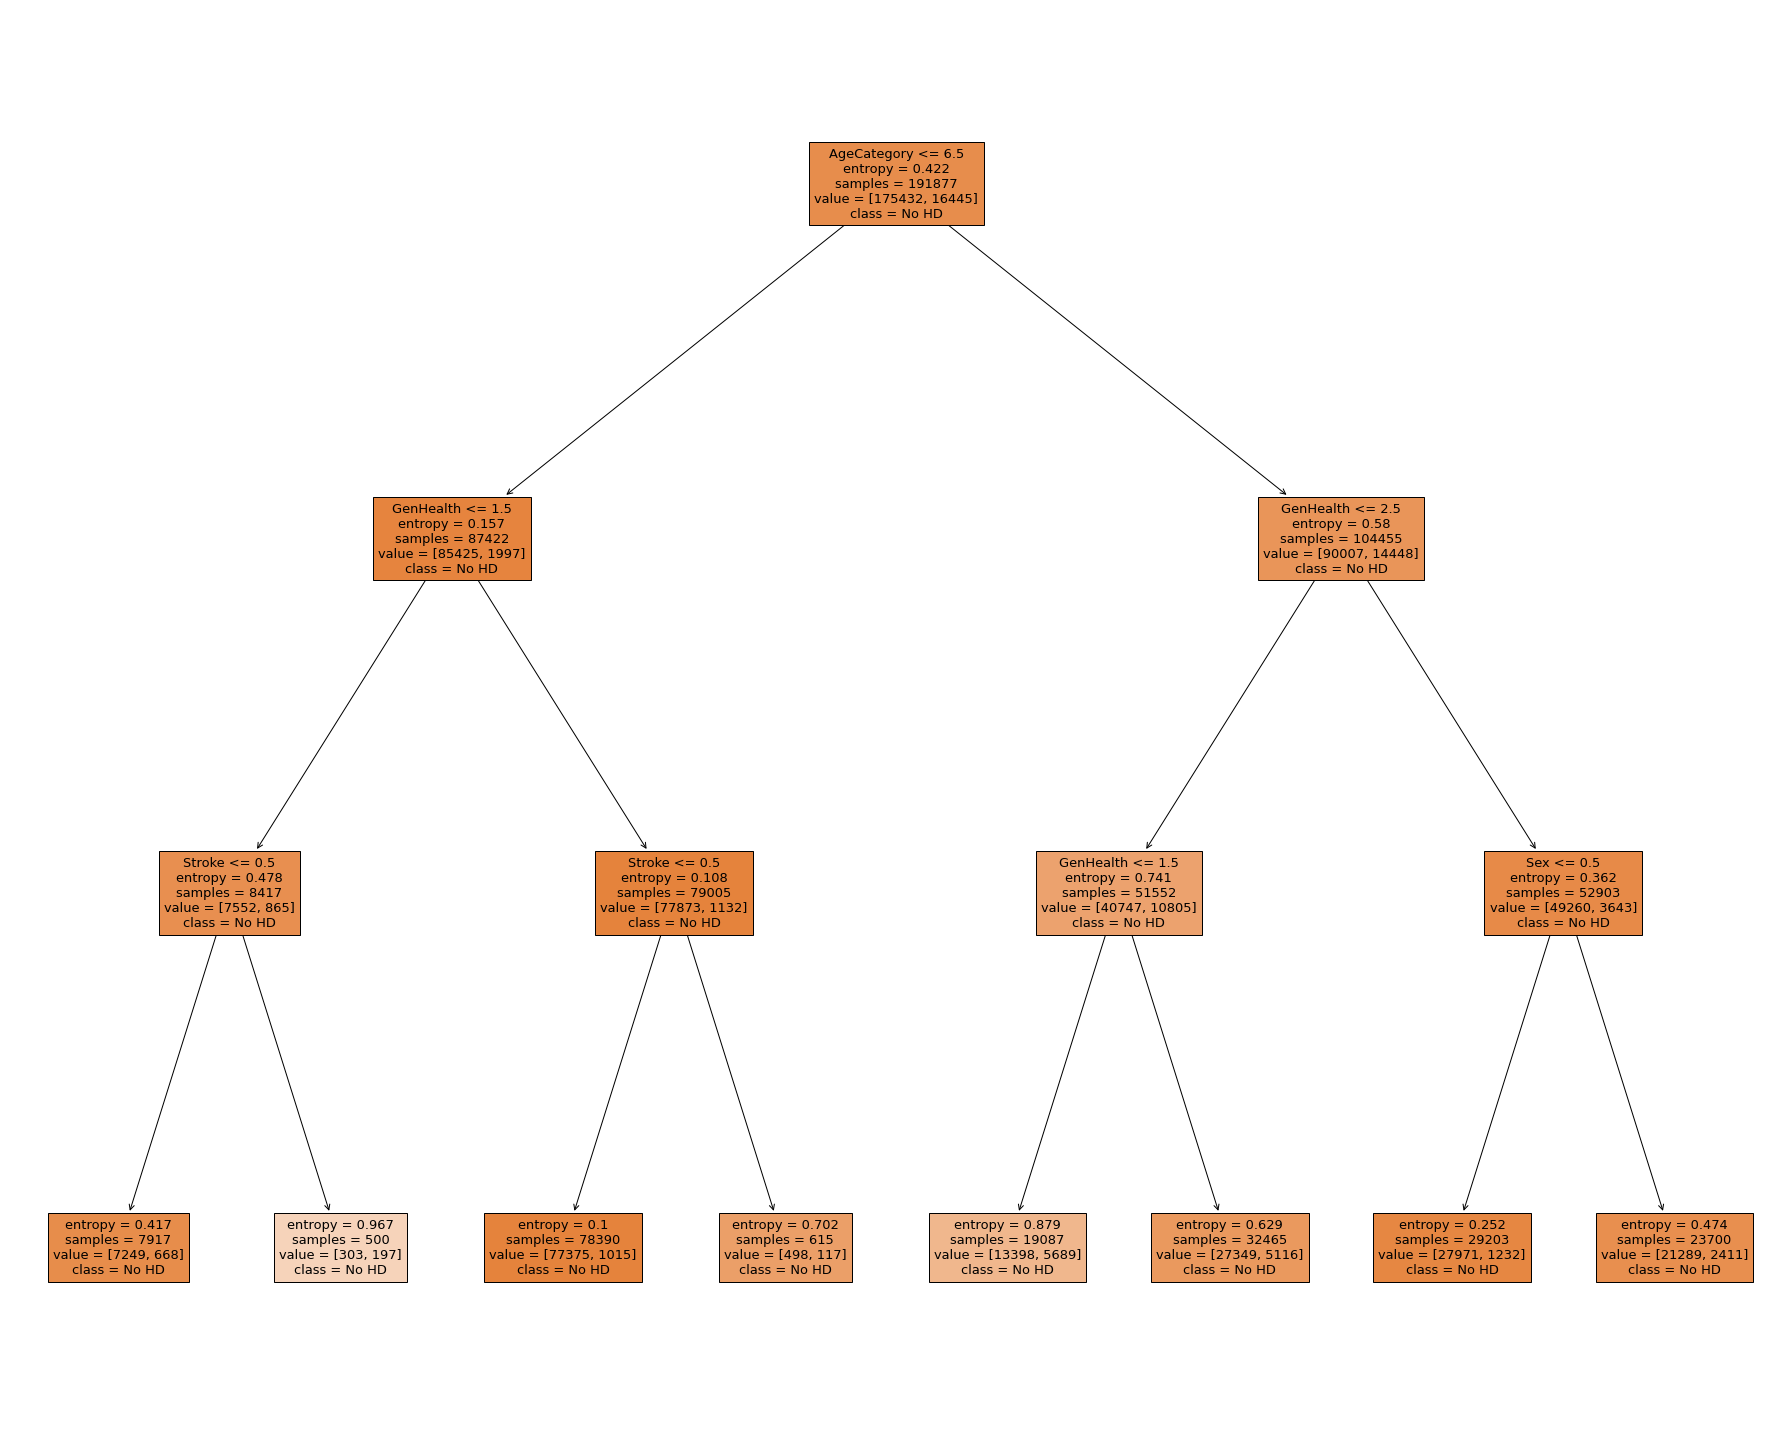

<Figure size 432x288 with 0 Axes>

In [32]:
#Plot a Decision Tree for presentation purposes
dtc = DecisionTreeClassifier(max_depth=3, criterion='entropy')
dtc.fit(train, target_train)
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dtc, feature_names=data.columns,class_names=['No HD', 'HD'], filled=True)
plt.tight_layout()
plt.savefig("figures/decistion_tree.png")
plt.show()
plt.clf()

 ## Define Functions for testing

In [33]:
# Function to automate training and prediction of a model; gets the model/algorithm and a bool which
# decides if the training dataset is to be evaluated as well; 
# output are the prediction array and predict_proba as 'notion of confidence'
def training(algorithm, pred_train=False):
    algorithm.fit(train, target_train)
    prediction = algorithm.predict(test)
    prediction_proba = algorithm.predict_proba(test)
    if pred_train == False:
        return prediction, prediction_proba
    else:   
        prediction_train = algorithm.predict(train)
        prediction_proba_train = algorithm.predict_proba(train)
        return prediction, prediction_proba, prediction_train, prediction_proba_train


In [34]:
# Various scoring functions
def comp_acc(prediction, truevalue):
    acc = accuracy_score(truevalue, prediction)
    return acc 

def comp_auc( prediction_proba, truevalue):
    auc = roc_auc_score(truevalue, prediction_proba[:, 1])
    return auc

def comp_roc( prediction_proba, truevalue):    
    fpr, tpr, thresholds = roc_curve(truevalue, prediction_proba[:, 1])
    return fpr, tpr, thresholds

In [35]:
# Cross Validation Function for accuracy, ROC AuC and recall
# Input: Model, train and target data and the number of splits cv
# Output: Mean of accuracy, ROC AuC and Recall after cross validation
def cross_val(algorithm, train=data, target=data_target, cv=5):
    scoring = {'acc': 'accuracy',
               'auc': 'roc_auc',
               'recall': 'recall'}

    results = cross_validate(algorithm, train, target, cv=cv, scoring=scoring, return_train_score=True)

    auc = results['test_auc']
    recall = results['test_recall']
    acc = results['test_acc']

    print(f'Area under RoC curve: {auc.mean():0.04f} ± {auc.std():0.04f}')
    print(f'Accuracy:             {acc.mean():0.04f} ± {acc.std():0.04f}')
    print(f'Recall:               {recall.mean():0.04f} ± {recall.std():0.04f}')
    return auc.mean(), acc.mean(), recall.mean()

In [37]:
# Function to evaluate the max_depth feature of the DTC
# Input: DTC criterion, Final depth value
# Output: Acc, Rec and ROC Plots
def check_maxdepth(criterion='entropy', max_value=20, plot_figure=False):
    training_acc =[]
    test_acc =[]
    roc=[]
    test_rec=[]
    training_rec=[]
    for i in range(1, max_value):
        algo = DecisionTreeClassifier(max_depth=i, criterion=criterion, random_state=137)
        prediction, prediction_proba, prediction_train, prediction_proba_train = training(algo, True)
        training_acc.append(accuracy_score(target_train, prediction_train))
        test_acc.append(accuracy_score(target_test, prediction))
        test_rec.append(recall_score(target_test, prediction))
        training_rec.append(recall_score(target_train, prediction_train))
        roc.append(roc_curve(target_test, prediction_proba[:,1]))

    plt.figure()
    plt.plot(range(1, max_value), training_acc, '--', label='Acc. Training Set')
    plt.plot(range(1, max_value), test_acc, color='darkred', label='Acc. Test Set')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Accuracy')
    plt.title('Accuracy DTC with ' + criterion)
    plt.legend()
    plt.tight_layout()
    plt.grid(alpha=0.4)
    path = 'figures/max_depth/max_depth_' + str(max_value) + '_Criterion_' + criterion + str('_acc.png')
    plt.savefig(path)
    plt.show()
    plt.clf()
    plt.figure()
    plt.plot(range(1, max_value), training_rec,'--', color='cornflowerblue', label='Rec. Training Set')
    plt.plot(range(1, max_value), test_rec, color='tomato', label='Rec. Test Set')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Recall')
    plt.title('Recall DTC with ' + criterion)
    plt.legend()
    plt.tight_layout()
    plt.grid(alpha=0.4)
    path = 'figures/max_depth/max_depth_' + str(max_value) + '_Criterion_' + criterion + str('_rec.png')
    plt.savefig(path)
    plt.show()
    plt.clf()
    plt.figure()
    plt.plot(roc[0][0], roc[0][1], '--', label='ROC with ' + str(1) + ' Maximum Depth')  
    for i in range(1, int(max_value/4)):
        name= 'ROC with ' + str(i*4) + ' Maximum Depth'
        plt.plot(roc[(i-1)*4][0], roc[(i-1)*4][1], '--', label=name)  
    plt.legend()
    plt.xlabel('False Postive Rate')
    plt.ylabel('False Negative Rate')
    plt.title('ROC curves DTC with ' + criterion)
    plt.grid(alpha=0.4)
    plt.tight_layout()
    path = 'figures/max_depth/ROCmax_depth' + str(max_value) + '_Criterion' + criterion + str('.png')
    plt.savefig(path)  
    plt.show()

## Test standard DTC

Checking max depth DTC with Entropy


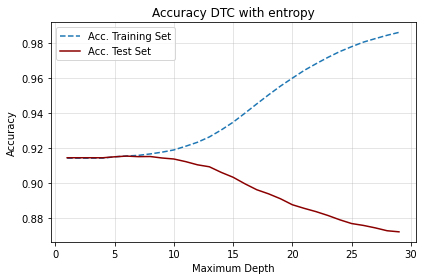

<Figure size 432x288 with 0 Axes>

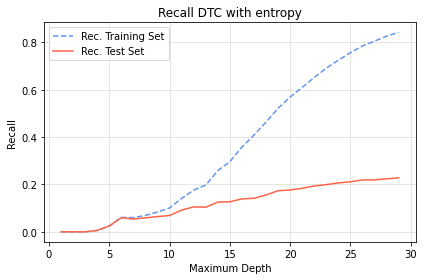

<Figure size 432x288 with 0 Axes>

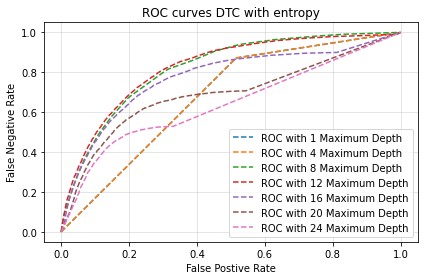

Checking max depth DTC with Gini


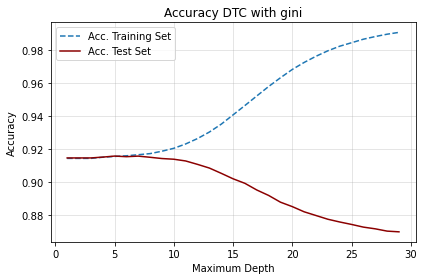

<Figure size 432x288 with 0 Axes>

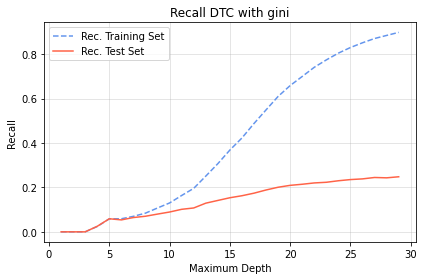

<Figure size 432x288 with 0 Axes>

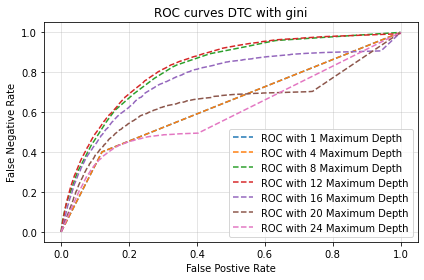

In [38]:
#Checking max depth of DTC with both criteria
print('Checking max depth DTC with Entropy')
check_maxdepth('entropy', 30)
print('Checking max depth DTC with Gini')
check_maxdepth('gini', 30)

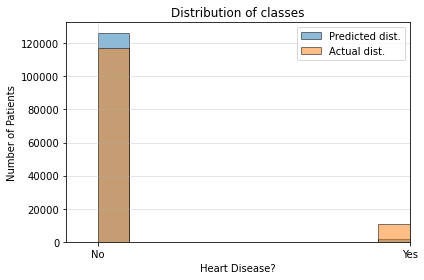

<Figure size 432x288 with 0 Axes>

In [39]:
#showcase of the mislabeled classes
dtc = DecisionTreeClassifier(max_depth=10, criterion='entropy', random_state=137)
pred, pred_proba = training(dtc)
plt.hist(pred, alpha=0.5, label='Predicted dist.', edgecolor='black')
plt.hist(target_test, alpha=0.5, label='Actual dist.', edgecolor='black')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.xlim(-0.1, 1)
plt.title('Distribution of classes')
plt.xlabel('Heart Disease?')
plt.ylabel('Number of Patients')
plt.legend()
plt.tight_layout()
plt.grid(alpha=0.4)
plt.savefig('figures/distributions/distribution_dtc.png')
plt.show()
plt.clf()

## Include Boosting Estimators

In [40]:
#Plot function to show off parameters of 
def plot_boosting_estimator(acc_test, acc_train, rec_test, rec_train, name):
    plt.figure()
    plt.plot(range(len(acc_test)), acc_test, color='red', linestyle='dotted', label='Acc. Test Set')
    plt.plot(range(len(acc_train)), acc_train, color='blue', linestyle='dotted', label='Acc. Train Set')
    plt.legend()
    plt.grid(alpha=0.4)
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
    plt.title('Accuracy of ' + name)
    plt.tight_layout()
    PATH='figures/boosting_est/acc' + name + '.png'
    plt.savefig(PATH)
    plt.show()
    plt.clf()
    
    plt.figure()
    plt.plot(range(len(rec_test)), rec_test, color='red', linestyle='dotted',label='Rec. Test Set')
    plt.plot(range(len(rec_train)), rec_train, color='blue', linestyle= 'dotted', label='Rec. Train Set')
    plt.legend()
    plt.grid(alpha=0.4)
    plt.ylabel('Recall')
    plt.xlabel('Iteration')
    plt.title('Recall of ' + name)
    plt.tight_layout()
    PATH='figures/boosting_est/rec' + name + '.png'
    plt.savefig(PATH)
    plt.show()
    plt.clf()

In [41]:
# test function to receive test scores of the booster algorithms for each iteration
def boosting_estimators(algo, name='ADA'):
    algo.fit(train, target_train)
    y_prediction = algo.predict(test)
    y_prediction_train = algo.predict(train)
    y_prediction_proba = algo.predict_proba(test)
    acc_test = [accuracy_score(y_prediction, target_test) for y_prediction in algo.staged_predict(test)]
    acc_train = [accuracy_score(y_prediction_train, target_train) for y_prediction_train in algo.staged_predict(train)]
    rec_test = [recall_score(y_prediction, target_test, zero_division=1) for y_prediction in algo.staged_predict(test)]
    rec_train = [recall_score(y_prediction_train, target_train, zero_division=1) for y_prediction_train in algo.staged_predict(train)]
    plot_boosting_estimator(acc_test, acc_train, rec_test, rec_train, name)

In [42]:
# Definition of used algorithms
classifier = [AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=300), 
             GradientBoostingClassifier(n_estimators=300),
             HistGradientBoostingClassifier(max_iter=300, early_stopping=False),
             CatBoostClassifier(n_estimators=300, verbose=0)]
names = ['AdaBoost', 'GradientBoost', 'HistGradientBoost', 'CatBoost']

check boosters
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=300) AdaBoost


/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


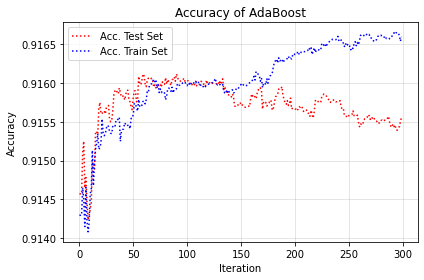

<Figure size 432x288 with 0 Axes>

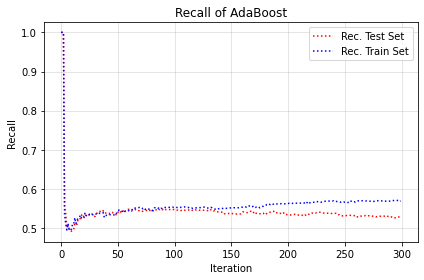

GradientBoostingClassifier(n_estimators=300) GradientBoost


<Figure size 432x288 with 0 Axes>

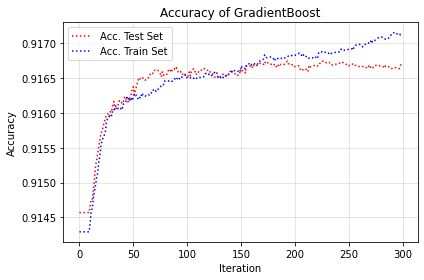

<Figure size 432x288 with 0 Axes>

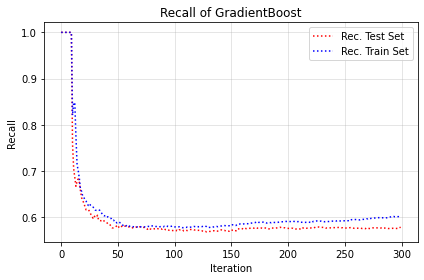

HistGradientBoostingClassifier(early_stopping=False, max_iter=300) HistGradientBoost


<Figure size 432x288 with 0 Axes>

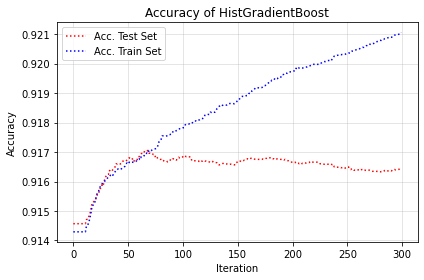

<Figure size 432x288 with 0 Axes>

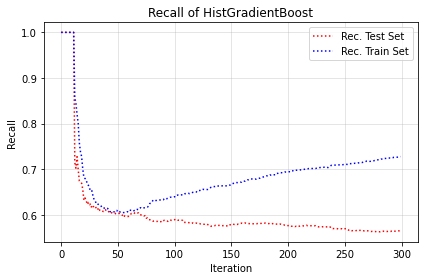

<catboost.core.CatBoostClassifier object at 0x7f0fb63d6cd0> CatBoost


<Figure size 432x288 with 0 Axes>

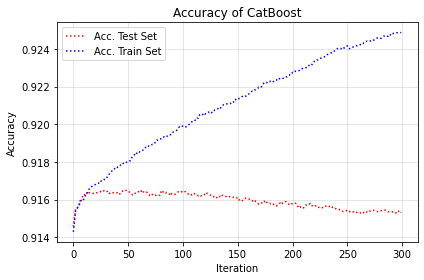

<Figure size 432x288 with 0 Axes>

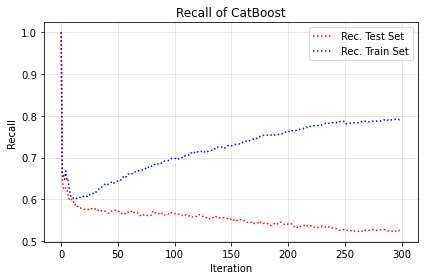

<Figure size 432x288 with 0 Axes>

In [43]:
print('check boosters')
for booster, name in zip(classifier, names):
    print(booster, name)
    boosting_estimators(booster, name)

In [44]:
# testing of XGBoost, since it is not fully compatible with scikit-learn
# no staged_predict in XGBoost so the model has to be defined for each stage again; 
# takes a  long computation time so only few iterations will be looked at
def xgb_test(max_est):
    acc_test=[]
    acc_train=[]
    x=[]
    rec_test=[]
    rec_train=[]
    for i in range(0, int(max_est/10)):
        model = xgb.XGBClassifier(n_estimators=(i*10)+1, eval_metric='logloss', use_label_encoder=False)
        model.fit(train, target_train)
        y_prediction = model.predict(test)#
        y_prediction_train = model.predict(train)
        y_prediction_proba = model.predict_proba(test)
        acc_test.append(accuracy_score( target_test, y_prediction))
        acc_train.append(accuracy_score(target_train, y_prediction_train))
        rec_test.append(recall_score(target_test, y_prediction))
        rec_train.append(recall_score(target_train, y_prediction_train))
        x.append(i*10 + 1)
        
    plot_boosting_estimator(acc_test, acc_train, rec_test, rec_train, 'eXtremeGradientBoost')

/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/s

/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


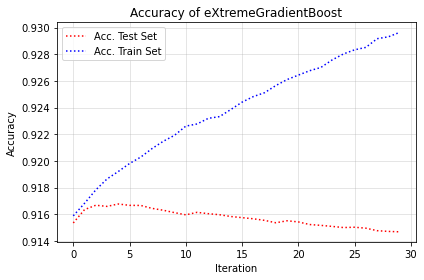

<Figure size 432x288 with 0 Axes>

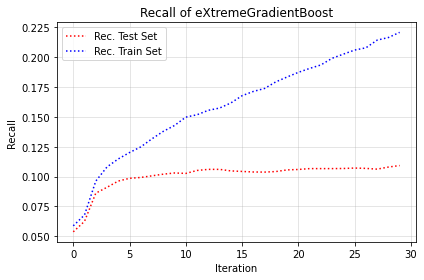

<Figure size 432x288 with 0 Axes>

In [45]:
xgb_test(300)

In [49]:
# Do a more comprehensive evaluation with cross evaluation
print('cross_eval All')
params=[]
classifier = [DecisionTreeClassifier(max_depth=10, criterion='entropy', random_state=137),
              DecisionTreeClassifier(max_depth=10, criterion='gini', random_state=137),
              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=120, random_state=137), 
              GradientBoostingClassifier(n_estimators=130, random_state=137),
              HistGradientBoostingClassifier(max_iter=130, early_stopping=True, random_state=137),
              CatBoostClassifier(n_estimators=50, verbose=0, random_state=137),
              xgb.XGBClassifier(n_estimators=80, eval_metric='logloss', use_label_encoder=False, random_state=137)]
names = ['DTC_entropy', 'DTC_gini', 'AdaBoost', 'GradientBoost', 'HistGradientBoost', 'CatBoost', 'XGBoost']
#for algo, name in zip(classifier, names):
#    print(name)
#    params.append(cross_val(algo))
    

cross_eval All


# Using Over and Under Sampling

In [26]:
# Plot function for evaluation of the sampling algorithms
def plot_sampling(score_type='Accuracy', scores=[], name_of_sampler=[], names=[], sampling_type='Under'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.grid(alpha=0.5)
    ax.scatter(np.linspace(0, 7, 7), scores[0], color='red', label=name_of_sampler[0])
    ax.scatter(np.linspace(0, 7, 7), scores[1], color='green', label=name_of_sampler[1])
    ax.scatter(np.linspace(0, 7, 7), scores[2], color='blue', label=name_of_sampler[2])
    plt.xticks(ticks= np.linspace(0, 7, 7), labels=names, rotation = 45)
    plt.legend()
    plt.tight_layout()
    plt.title(score_type + ' ' + sampling_type + ' Sampler')
    plt.ylabel(score_type)
    plt.xlabel('Models')
    plt.savefig('figures/Sampling/' + score_type + sampling_type + '.png')
    plt.show()
    plt.clf()

In [19]:
# test function of sampling algorithms
# Input: Sampling Algorithm, Classfier, Name of Classifier
# Output: cross evaluated ROC AuC, accuracy, recall
def test_sampling(sampler, classifier, names):      
    acc=[]
    auc=[]
    rec=[]
    for algo, name in zip(classifier, names):
        print(name)
        model= make_pipeline(sampler, algo)
        params = cross_val(model)
        auc.append(params[0])
        acc.append(params[1])
        rec.append(params[2])
        
    return auc, acc, rec   

### Over Sampling

In [20]:
print('ROS')
auc_ROS, acc_ROS, rec_ROS = test_sampling(RandomOverSampler(random_state=137), classifier, names)

ROS
DTC_entropy
Area under RoC curve: 0.8180 ± 0.0039
Accuracy:             0.7281 ± 0.0058
Recall:               0.7838 ± 0.0106
DTC_gini
Area under RoC curve: 0.8165 ± 0.0046
Accuracy:             0.7308 ± 0.0060
Recall:               0.7787 ± 0.0106
AdaBoost
Area under RoC curve: 0.8390 ± 0.0030
Accuracy:             0.7351 ± 0.0054
Recall:               0.7959 ± 0.0133
GradientBoost
Area under RoC curve: 0.8432 ± 0.0027
Accuracy:             0.7376 ± 0.0055
Recall:               0.8022 ± 0.0134
HistGradientBoost
Area under RoC curve: 0.8427 ± 0.0029
Accuracy:             0.7389 ± 0.0054
Recall:               0.7978 ± 0.0132
CatBoost
Area under RoC curve: 0.8421 ± 0.0027
Accuracy:             0.7410 ± 0.0049
Recall:               0.7958 ± 0.0112
XGBoost


/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/s

Area under RoC curve: 0.8367 ± 0.0036
Accuracy:             0.7458 ± 0.0056
Recall:               0.7770 ± 0.0120


In [21]:
print('SMOTE')
auc_SMOTE, acc_SMOTE, rec_SMOTE  = test_sampling(SMOTE(random_state=137), classifier, names)

SMOTE
DTC_entropy
Area under RoC curve: 0.7869 ± 0.0024
Accuracy:             0.7503 ± 0.0065
Recall:               0.6799 ± 0.0127
DTC_gini
Area under RoC curve: 0.7880 ± 0.0024
Accuracy:             0.7518 ± 0.0075
Recall:               0.6760 ± 0.0148
AdaBoost
Area under RoC curve: 0.7847 ± 0.0034
Accuracy:             0.8293 ± 0.0023
Recall:               0.4544 ± 0.0128
GradientBoost
Area under RoC curve: 0.7981 ± 0.0020
Accuracy:             0.7915 ± 0.0022
Recall:               0.5962 ± 0.0073
HistGradientBoost
Area under RoC curve: 0.7955 ± 0.0019
Accuracy:             0.8131 ± 0.0019
Recall:               0.5262 ± 0.0074
CatBoost
Area under RoC curve: 0.7910 ± 0.0021
Accuracy:             0.8171 ± 0.0010
Recall:               0.5083 ± 0.0054
XGBoost


/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/s

Area under RoC curve: 0.7882 ± 0.0018
Accuracy:             0.8341 ± 0.0006
Recall:               0.4416 ± 0.0047


In [22]:
print('ADASYN')
auc_ADASYN, acc_ADASYN, rec_ADASYN = test_sampling(ADASYN(random_state=137), classifier, names)

# Save data
import json
with open("oversampling.json", "w") as f:
    json.dump([auc_ROS, acc_ROS, rec_ROS, auc_SMOTE, acc_SMOTE, rec_SMOTE, auc_ADASYN, acc_ADASYN, rec_ADASYN], f)

ADASYN
DTC_entropy
Area under RoC curve: 0.7796 ± 0.0029
Accuracy:             0.7277 ± 0.0141
Recall:               0.6953 ± 0.0141
DTC_gini
Area under RoC curve: 0.7795 ± 0.0022
Accuracy:             0.7281 ± 0.0160
Recall:               0.6907 ± 0.0161
AdaBoost
Area under RoC curve: 0.7786 ± 0.0036
Accuracy:             0.8264 ± 0.0020
Recall:               0.4436 ± 0.0103
GradientBoost
Area under RoC curve: 0.7915 ± 0.0017
Accuracy:             0.7815 ± 0.0023
Recall:               0.5952 ± 0.0084
HistGradientBoost
Area under RoC curve: 0.7891 ± 0.0021
Accuracy:             0.8079 ± 0.0012
Recall:               0.5185 ± 0.0058
CatBoost
Area under RoC curve: 0.7844 ± 0.0024
Accuracy:             0.8115 ± 0.0007
Recall:               0.5031 ± 0.0043
XGBoost


/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/s

Area under RoC curve: 0.7817 ± 0.0025
Accuracy:             0.8305 ± 0.0019
Recall:               0.4369 ± 0.0065


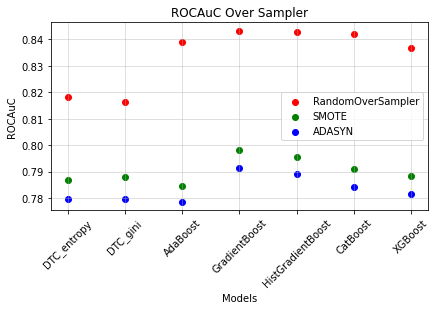

<Figure size 432x288 with 0 Axes>

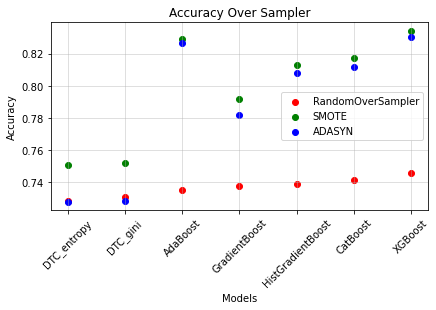

<Figure size 432x288 with 0 Axes>

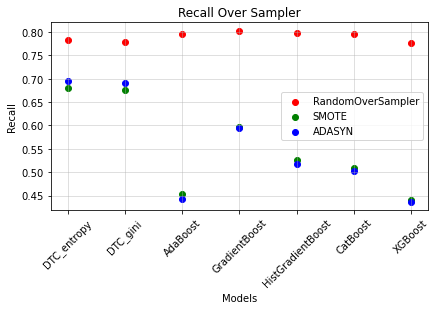

<Figure size 432x288 with 0 Axes>

In [27]:
plot_sampling('ROCAuC', [auc_ROS, auc_SMOTE, auc_ADASYN], ['RandomOverSampler', 'SMOTE', 'ADASYN'], names, 'Over')
plot_sampling('Accuracy', [acc_ROS, acc_SMOTE, acc_ADASYN], ['RandomOverSampler', 'SMOTE', 'ADASYN'], names, 'Over')
plot_sampling('Recall', [rec_ROS, rec_SMOTE, rec_ADASYN], ['RandomOverSampler', 'SMOTE', 'ADASYN'], names, 'Over')

### Under Sampling

In [50]:
print('RUS')
auc_RUS, acc_RUS, rec_RUS = test_sampling(RandomUnderSampler(random_state=137), classifier, names)

RUS
DTC_entropy
Area under RoC curve: 0.8173 ± 0.0033
Accuracy:             0.7232 ± 0.0099
Recall:               0.7870 ± 0.0158
DTC_gini
Area under RoC curve: 0.8151 ± 0.0027
Accuracy:             0.7283 ± 0.0107
Recall:               0.7778 ± 0.0167
AdaBoost
Area under RoC curve: 0.8372 ± 0.0028
Accuracy:             0.7310 ± 0.0047
Recall:               0.8010 ± 0.0093
GradientBoost
Area under RoC curve: 0.8428 ± 0.0026
Accuracy:             0.7350 ± 0.0063
Recall:               0.8051 ± 0.0139
HistGradientBoost
Area under RoC curve: 0.8422 ± 0.0027
Accuracy:             0.7309 ± 0.0068
Recall:               0.8088 ± 0.0118
CatBoost
Area under RoC curve: 0.8412 ± 0.0026
Accuracy:             0.7351 ± 0.0056
Recall:               0.8024 ± 0.0140
XGBoost


/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/s

Area under RoC curve: 0.8367 ± 0.0029
Accuracy:             0.7316 ± 0.0062
Recall:               0.7968 ± 0.0120


In [51]:
print('IHT')
auc_IHT, acc_IHT, rec_IHT = test_sampling(InstanceHardnessThreshold(random_state=137), classifier, names)

IHT
DTC_entropy
Area under RoC curve: 0.8051 ± 0.0032
Accuracy:             0.7201 ± 0.0128
Recall:               0.7923 ± 0.0189
DTC_gini
Area under RoC curve: 0.8049 ± 0.0017
Accuracy:             0.7225 ± 0.0058
Recall:               0.7898 ± 0.0088
AdaBoost
Area under RoC curve: 0.8292 ± 0.0031
Accuracy:             0.6938 ± 0.0090
Recall:               0.8314 ± 0.0122
GradientBoost
Area under RoC curve: 0.8326 ± 0.0024
Accuracy:             0.7034 ± 0.0082
Recall:               0.8281 ± 0.0134
HistGradientBoost
Area under RoC curve: 0.8315 ± 0.0024
Accuracy:             0.6896 ± 0.0099
Recall:               0.8366 ± 0.0114
CatBoost
Area under RoC curve: 0.8321 ± 0.0024
Accuracy:             0.6953 ± 0.0090
Recall:               0.8321 ± 0.0118
XGBoost


/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/s

Area under RoC curve: 0.8308 ± 0.0026
Accuracy:             0.6900 ± 0.0099
Recall:               0.8336 ± 0.0119


In [56]:
print('NM')
auc_NM, acc_NM, rec_NM = test_sampling(NearMiss(n_jobs=4), classifier, names)

NM
DTC_entropy
Area under RoC curve: 0.5677 ± 0.0045
Accuracy:             0.3605 ± 0.0173
Recall:               0.8049 ± 0.0184
DTC_gini
Area under RoC curve: 0.5653 ± 0.0044
Accuracy:             0.3633 ± 0.0261
Recall:               0.8015 ± 0.0306
AdaBoost
Area under RoC curve: 0.5529 ± 0.0141
Accuracy:             0.2682 ± 0.0171
Recall:               0.8520 ± 0.0173
GradientBoost
Area under RoC curve: 0.6159 ± 0.0045
Accuracy:             0.3061 ± 0.0179
Recall:               0.8438 ± 0.0196
HistGradientBoost
Area under RoC curve: 0.5826 ± 0.0089
Accuracy:             0.2661 ± 0.0170
Recall:               0.8539 ± 0.0170
CatBoost
Area under RoC curve: 0.6029 ± 0.0085
Accuracy:             0.2687 ± 0.0115
Recall:               0.8564 ± 0.0169
XGBoost


/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/s

Area under RoC curve: 0.5771 ± 0.0078
Accuracy:             0.2604 ± 0.0114
Recall:               0.8530 ± 0.0176


In [57]:
with open("undersampling.json", "w") as f:
    json.dump([auc_RUS, acc_RUS, rec_RUS, auc_IHT, acc_IHT, rec_IHT, auc_NM, acc_NM, rec_NM], f)

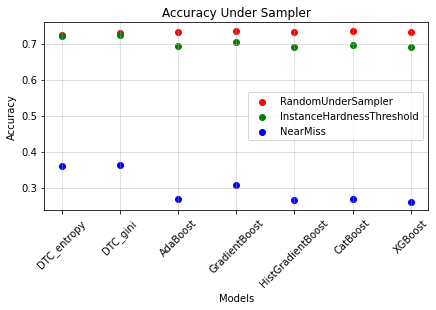

<Figure size 432x288 with 0 Axes>

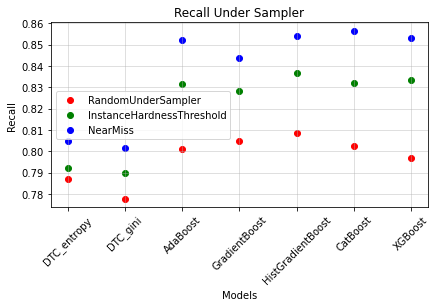

<Figure size 432x288 with 0 Axes>

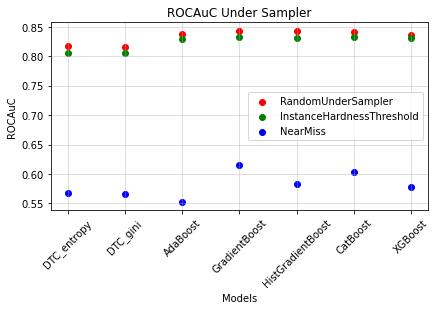

<Figure size 432x288 with 0 Axes>

In [60]:
plot_sampling('Accuracy', [acc_RUS, acc_IHT, acc_NM], ['RandomUnderSampler', 'InstanceHardnessThreshold', 'NearMiss'], names, 'Under')
plot_sampling('Recall', [rec_RUS, rec_IHT, rec_NM], ['RandomUnderSampler', 'InstanceHardnessThreshold', 'NearMiss'], names, 'Under')
plot_sampling('ROCAuC', [auc_RUS, auc_IHT, auc_NM], ['RandomUnderSampler', 'InstanceHardnessThreshold', 'NearMiss'], names, 'Under')